#### **Deep & Reinforcement Learning**

#### **Observações**

##### Classificando notícias com Redes Neurais Recorrentes 📰
Imagine que temos o desafio de organizar diversos tipos de notícias por assuntos, como você faria? Basicamente podemos classificar uma notícia dado algum contexto, por exemplo:

"Pela quarta rodada do Campeonato Italiano, a Roma não tomou conhecimento do Empoli neste domingo e venceu pela primeira vez na competição."

Com base nesse contexto, poderiamos classificar essa notícia como do tipo "Esportes", certo? E por que sabemos disso? Bem, podemos observar algumas palavrinhas chaves tal como "campeonato" e "competição".

Nessa aula, temos o desafio de ensinar uma rede neural recorrente realizar esse tipo de trabalho! Classificar notícias com base em textos.

Como bem já sabemos, as redes neurais recorrentes aprende com ela mesma (assim como nós humanos aprendemos com nossos erros). Basicamente, esse tipo de arquitetura aprende não só com os dados de entrada mas também com as próprias saídas da rede (muito parecido com um looping de aprendizado, por isso chamamos de redes recorrentes). Como nesse cenário precisamos de uma sequência de palavras para fazer sentido ao contexto, as RNNs podem ser uma boa alternativa! Vamos codar? 😀

##### **Limpeza dos dados** 🧹

Antes de iniciar as etapas de pré-processamento que citei anteriormente, vamos precisar limpar os dados. Vamos ciar uma função que realize a etapa de limpeza do texto utilizando alguns REGEX, remoção de stop words e lematizar algumas palavras.

Para contextuallizar o que fazem essas técnicas, vamos falar um pouquinho mais sobre elas.

**Regex**  
Pode ser definida como uma **forma flexível de identificar determinada cadeia de caractere** para nosso interesse. Uma cadeia pode ser um caractere específico, uma palavra ou um padrão.
No Python, o módulo **re** provê um analisador sintático que permite o uso de tais expressões. Os padrões definidos através de caracteres que tem significado especial para o analisador.

**Stop-words**  
Essa técnica consiste na **remoção de ruídos** do texto que são menos evidentes que pontuações, como os conectivos “que”, “o”, “a”, “de”, entre outros. Normalmente é um conjunto composto por artigos, advérbios, preposições e alguns verbos.

**Lematização**  
Basicamente é um processo que determina uma única “raiz” para a palavra, independente de suas diferenças superficiais.

##### **Entrando no preparo dos dados!** 📏

**Tokenização e vetorização**  

**Tokenização**  
A tokenização é uma etapa inicial no processo de NLP para dividir frases de texto em palavras ou tokens menores. Por exemplo: "O time venceu a partida" ficaria "o", "time", "venceu", "a", "partida".

E porque precisamos tokenizar?

É necessário para identficar cada uma das palavras contidas na base.

**Vetorização**  
A máquina não entende texto ou palavras, portanto, dados de texto ou tokens devem ser **convertidos em índices de palavras ou vetores de palavras** para processar texto e construir modelos. Por exemplo,  "o: 1", "time: 2", "venceu: 3", "a: 4", "partida: 5".

##### **Como criar ambientes para evitar conflito:**
https://github.com/RicardViana/fiap-data-viz-and-production-models/blob/main/Roteiro%20para%20cria%C3%A7%C3%A3o%20de%20ambiente.pdf

#### **Conteúdo - Bases e Notebook da aula**

Github:  
https://github.com/FIAP/Pos_Tech_DTAT/tree/DeepLearning

ou

https://github.com/FIAP/Pos_Tech_DTAT/tree/main


#### **Importação de bibliotecas**

In [30]:
#Importar biblioteca completa
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('wordnet')
import os

#Importar algo especifico de uma biblioteca
from wordcloud import STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.src.legacy.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import L1L2

from keras.layers import (
    Input, 
    Embedding, 
    LSTM, 
    GRU, 
    SimpleRNN, 
    Bidirectional, 
    Conv1D, 
    MaxPooling1D, 
    Dropout, 
    Dense
)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ricar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### **Funções (def)**

In [2]:
# regex para limpar o texto
def limpeza_texto(text):
    
    whitespace = re.compile(r"\s+")                            # encontrando espaços em branco
    user = re.compile(r"(?i)@[a-z0-9_]+")                      # encontrar menções de usuários, exemplo @usuario
    text = whitespace.sub(' ', text)                           # substitui espaços em branco por ' '
    text = user.sub('', text)                                  # remove todas as menções de usuário encontradas no texto
    text = re.sub(r"\[[^()]*\]","", text)                      # remove o conteúdo dentro de colchetes, incluindo os colchetes
    text = re.sub("\d+", "", text)                             # remove todos os dígitos numéricos do texto
    text = re.sub(r'[^\w\s]','',text)                          # remove todos os caracteres que não são palavras (letras e números) ou espaços em branco.
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text) # remove menções de usuário, hashtags e URLs.
    text = text.lower()                                        # texto para minusculo

    # removendo as stop words
    text = [word for word in text.split() if word not in list(STOPWORDS)]

    # word lemmatization
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))

    return ' '.join(sentence)

#### **Aula 4 - Redes recorrentes**

In [3]:
# Criar o DF com a base BBC TEXT
link = "https://raw.githubusercontent.com/RicardViana/fiap-Deep-Learning-and-unstructured-data/refs/heads/main/bbc-text.csv"
df = pd.read_csv(link, sep=",")

# Fazer uma copia do DF caso precise consultar os dados originais
df_2 = df.copy()

In [4]:
# Ver o data frame
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [5]:
# Ver a qtd de linhas e colunas
df.shape

(2225, 2)

In [6]:
# Ver os dados unico da category
df['category'].nunique()

5

In [7]:
# Ver os dados unico 
set(df['category'])

{'business', 'entertainment', 'politics', 'sport', 'tech'}

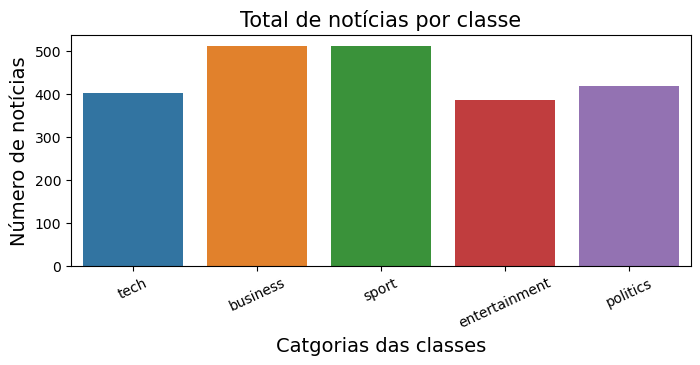

In [8]:
# Ver a distribuição da category em um grafico 
plt.figure(figsize=(8,3))
sns.countplot(data=df, x='category', hue='category')
plt.title("Total de notícias por classe", size=15)
plt.xlabel("Catgorias das classes", size=14)
plt.xticks(rotation=25)
plt.ylabel("Número de notícias", size=14)
plt.show()

In [9]:
# Comparar o texto antes e depois da limpeza
print("Texto antes da limpeza:\n",df['text'][0])
print("---"*100)
print("Texto depois da limpeza:\n",limpeza_texto(df['text'][0]))

Texto antes da limpeza:
 tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are als

In [10]:
# Aplicando a função no dataframe inteiro
df['text'] = df['text'].apply(limpeza_texto)

In [11]:
# comprimento do total de caracteres antes e depois da limpeza dos dados de texto
antigo_total_caracter = df_2['text'].apply(len).sum()
novo_total_caracter = df['text'].apply(len).sum()

print(f"Tamanho de caracteres antes da limpeza: {antigo_total_caracter}")
print(f"Tamanho de caracteres depois da limpeza: {novo_total_caracter}")

Tamanho de caracteres antes da limpeza: 5035033
Tamanho de caracteres depois da limpeza: 3282790


In [12]:
# workflow de tokenização e vetorização
# codificação one-hot de nível de palavra para dados de amostra

samples = list(df['text'][:5].values)  # amostras dos primeiros cinco documentos do nosso conjunto de dados

token_index = {} # cria um índice de tokens nos dados
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1 # atribuindo índice exclusivo para cada palavra única

max_length = 15 # Define um valor máximo para o comprimento das sequências. Todas as sequências terão esse comprimento, e as palavras adicionais serão truncadas se necessário

results = np.zeros(shape=(len(samples),   # resultados serão armazenados neste array multidimensional de zeros com as dimensões obtidas pelo tamanho das amostras e o tamanho máximo de comprimento
                          max_length,     # Esta matriz será usada para armazenar a codificação one-hot das palavras em cada sequência de amostra
                          max(token_index.values()) +1))

print("Shape de resultados armazenados:", results.shape)
print("Índice de token de palavras únicas: \n", token_index)

# criando a matriz one hot econdig
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i,j,index] = 1

Shape de resultados armazenados: (5, 15, 680)
Índice de token de palavras únicas: 
 {'tv': 1, 'future': 2, 'hand': 3, 'viewers': 4, 'home': 5, 'theatre': 6, 'systems': 7, 'plasma': 8, 'highdefinition': 9, 'tvs': 10, 'digital': 11, 'video': 12, 'recorders': 13, 'move': 14, 'live': 15, 'room': 16, 'way': 17, 'people': 18, 'watch': 19, 'will': 20, 'radically': 21, 'different': 22, 'five': 23, 'years': 24, 'time': 25, 'accord': 26, 'expert': 27, 'panel': 28, 'gather': 29, 'annual': 30, 'consumer': 31, 'electronics': 32, 'show': 33, 'las': 34, 'vegas': 35, 'discuss': 36, 'new': 37, 'technologies': 38, 'impact': 39, 'one': 40, 'favourite': 41, 'pastimes': 42, 'us': 43, 'lead': 44, 'trend': 45, 'program': 46, 'content': 47, 'deliver': 48, 'via': 49, 'network': 50, 'cable': 51, 'satellite': 52, 'telecoms': 53, 'company': 54, 'broadband': 55, 'service': 56, 'providers': 57, 'front': 58, 'portable': 59, 'devices': 60, 'talkedabout': 61, 'ces': 62, 'personal': 63, 'dvr': 64, 'pvr': 65, 'settop': 

In [13]:
# Aplicando LabelEncoder nas categorias para converter rótulos de classes de texto ou categorias em números inteiros
X = df['text']
encoder = LabelEncoder()
y = encoder.fit_transform(df['category'])

print("tamanho dos dados de entrada: ", X.shape)
print("tamanho da variável alvo: ", y.shape)

# Seprando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Criando a tokenização
# Tendo agora as palavras em uma grande lista (1000), usamos a classe Tokenizer para tokenização das palavras e criação de um vocabulário
# com as 1000 palavras mais frequentes no texto(parâmetro num_words do Tokenizer):
tokenizer = Tokenizer(num_words=1000, oov_token='<00V>')  # OOV = out of vocabulary (fora de vocabulário)
tokenizer.fit_on_texts(X_train) # construindo o índice de palavras

# Preenchimento de dados de entrada de texto X_train
train_seq = tokenizer.texts_to_sequences(X_train) #converte strings em listas inteiras
train_padseq = pad_sequences(train_seq, maxlen=200) # preenche as listas de inteiros para o tensor de inteiros 2D
# maxlen define o comprimento máximo desejado para as sequências após o preenchimento (padding)

# preenchimento de dados de entrada de texto X_test
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=200)

word_index = tokenizer.word_index
max_words = 1500  # número total de palavras a serem consideradas na camada de incorporação
total_words = len(word_index)
maxlen = 200 # comprimento máximo da sequência
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)
print("Tamanho do índice de palavras:", total_words)

tamanho dos dados de entrada:  (2225,)
tamanho da variável alvo:  (2225,)
Tamanho do índice de palavras: 22787


In [14]:
# Consultar o total de palavras
total_words

22787

In [15]:
'''

## Finalmente, aplicando a RNN! 📰

A rede numérica recorrente processa sequências iterando através dos elementos da sequência e mantendo um estado contendo informações relativas ao que viu até agora.
Na verdade, uma RNN é um tipo de rede numérica que possui um loop interno.

'''

# utilizando a SimpleRNN em conjunto com embeddings
tf.random.set_seed(44)

model = Sequential()

# 1. Adicionamos a camada de Input explicitamente (Boa prática no Keras 3)
model.add(Input(shape=(maxlen,))) 

# 2. Removemos o input_length do Embedding
model.add(Embedding(total_words, 70)) 

# 3. Restante das camadas permanece igual
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 70)        │     1,595,090 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 128)       │        17,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,642,391 (6.27 MB)

 Trainable params: 1,642,391 (6.27 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Gerando o modelo

model.compile(optimizer='adam', # Adam, que é um algoritmo de otimização amplamente utilizado para ajustar os pesos da rede neural durante o treinamento.
            loss='categorical_crossentropy', # função de perda a ser minimizada durante o treinamento
            metrics=['accuracy'] # métrica de avaliação para monitorar durante o treinamento
            )

# Configurando early stopping corretamente
earlystopping = EarlyStopping(
    monitor='val_loss', # Melhor monitorar a perda de validação
    patience=3, 
    verbose=1, 
    mode='min' # Queremos que o erro diminua
)

# Configurando o checkpointer (corrigido 'monitor')
checkpointer = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True
)

callback_list = [checkpointer, earlystopping]

# treinando o modelo 
history = model.fit(
    train_padseq, y_train,
    batch_size=120,
    epochs=15,
    validation_split=0.2,
    callbacks=callback_list
)

# validando o modelo
test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.2060 - loss: 1.8757
Epoch 1: val_loss improved from None to 1.70659, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 695ms/step - accuracy: 0.2001 - loss: 1.8428 - val_accuracy: 0.1854 - val_loss: 1.7066
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.2134 - loss: 1.7994
Epoch 2: val_loss improved from 1.70659 to 1.67143, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 594ms/step - accuracy: 0.2037 - loss: 1.7884 - val_accuracy: 0.2191 - val_loss: 1.6714
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.2324 - loss: 1.7228
Epoch 3: val_loss improved from 1.67143 to 1.66263, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 609ms/step - accuracy: 0.2268 - loss: 1.7328 - val_accuracy: 0.2331 - val_loss: 1.6626
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.2228 - loss: 1.7233
Epoch 4: val_loss improved from 1.66263 to 1.65975, 

In [23]:
# Define o nome do arquivo
nome_arquivo = "model.keras"

# Cria o caminho completo dinamicamente
caminho_completo = os.path.join(os.getcwd(), nome_arquivo)

# Salva o modelo
model.save(caminho_completo)

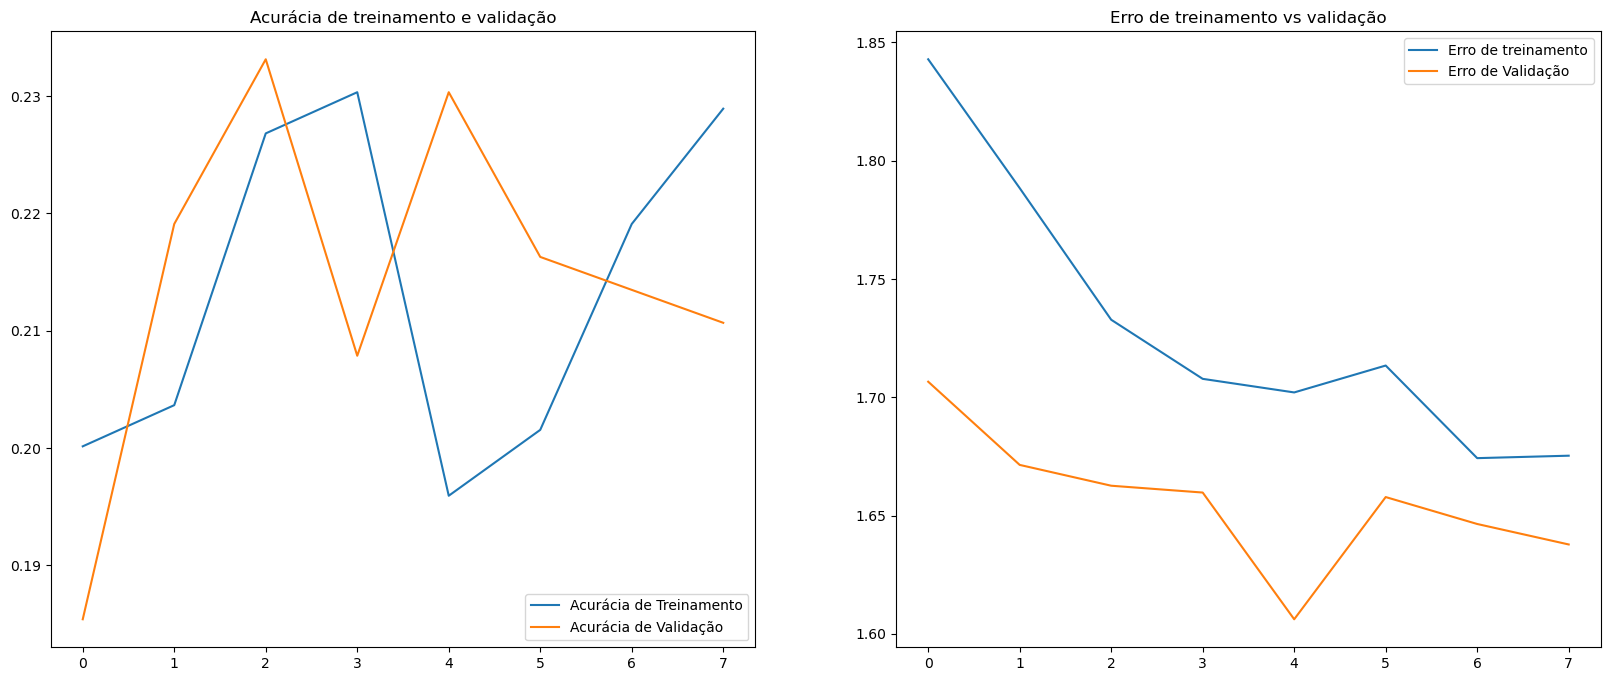

In [24]:
# Visualizar resultados
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de treinamento e validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erro de treinamento')
plt.plot(epochs_range, val_loss, label='Erro de Validação')
plt.legend(loc='upper right')
plt.title('Erro de treinamento vs validação')
plt.show()

In [31]:
'''

Testando com LSTM, RNN e GRU

Além de testar agora com algumas camadas da LSTM, vamos também acrescentar uma cadama GRU (Gated Recurrent Unit) que também tem o objetivo de abordar algumas das limitações das camadas RNN tradicionais,
como o problema do desaparecimento do gradiente. A GRU introduz mecanismos de portão que permitem que a rede aprenda quais informações devem ser lembradas e quais podem ser esquecidas durante o processamento
de sequências, bem parecida com a LSTM!

LSTM é um tipo especial de rede neural recorrente, pois são capazes de aprender conexões de longo prazo. 
Dessa maneira, elas têm um incrível poder de predição e funcionam muito bem em uma variada gama de problemas que envolvem capturas de padrões de longo prazo.

'''

tf.random.set_seed(44)

model2 = Sequential()

# Adicionamos a camada Input e removemos o input_length do Embedding para o Keras 3
model2.add(Input(shape=(maxlen,)))
model2.add(Embedding(total_words, 100))

# Camadas Bidirecionais
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))

# Camadas Convolucionais
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))

# Camada RNN intermediária
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))

# Camada GRU final corrigida (usando o objeto L1L2 em vez da string 'l1_l2')
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer=L1L2(l1=1e-5, l2=1e-4)))

model2.add(Dropout(0.2))
model2.add(Dense(5, activation='softmax'))

model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 200, 100)       │     2,278,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 200, 128)       │        84,480 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 200, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 200, 128)       │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 198, 72)        │        27,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 99, 72)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 99, 64)         │         8,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,548,473 (9.72 MB)

 Trainable params: 2,548,473 (9.72 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 1. Compilando o Modelo 2

model2.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# 2. Configurando o Early Stopping (Monitorando val_loss para evitar overfitting)
earlystopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    verbose=1, 
    mode='min' # Interrompe quando o erro de validação para de cair
)

# 3. Configurando o Checkpointer (Salvando a melhor versão do modelo híbrido)
# Usando o formato dinâmico .keras para o Keras 3
checkpointer = ModelCheckpoint(
    filepath='best_model2_hibrido.keras', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True
)

callback_list = [checkpointer, earlystopping]

# 4. Treinando o modelo (Certifique-se de passar a lista de callbacks aqui)
history = model2.fit(
    train_padseq, y_train,
    batch_size=120,
    epochs=15,
    validation_split=0.2,
    callbacks=callback_list # Importante para ativar o Checkpoint e EarlyStopping
)

# 5. Validando o modelo com os dados de teste
test_loss, test_acc = model2.evaluate(test_padseq, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1804 - loss: 1.6821
Epoch 1: val_loss improved from None to 1.61687, saving model to best_model2_hibrido.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.1875 - loss: 1.6684 - val_accuracy: 0.2191 - val_loss: 1.6169
Epoch 2/15
 2/12 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.2479 - loss: 1.6389

In [ ]:
# Visualizar resultados
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de treinamento e validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erro de treinamento')
plt.plot(epochs_range, val_loss, label='Erro de Validação')
plt.legend(loc='upper right')
plt.title('Erro de treinamento vs validação')
plt.show()

In [ ]:
# Define o nome do arquivo
nome_arquivo = "model2.keras"

# Cria o caminho completo dinamicamente
caminho_completo = os.path.join(os.getcwd(), nome_arquivo)

# Salva o modelo
model.save(caminho_completo)

In [ ]:
'''

Realizar um teste com um novo dado para finalizar com chave de ouro essa aula?

'''

# Pré-processamento (tokenização e vetorização)
new_text = "Almost immediately following USA Basketball's fourth-place finish at the 2023 FIBA World Cup, NBA superstar LeBron James made it known he wants to participate in one final Olympics next summer in Paris."
new_text = limpeza_texto(new_text)

# Vetorização e ajuste de tamanho da sequência
new_sequence = tokenizer.texts_to_sequences([new_text])
new_sequence = pad_sequences(new_sequence, maxlen=maxlen)

# Faz a previsão
predictions = model2.predict(new_sequence)

# Obtendo os resultados
class_names = ['business 0', 'entertainmente 1', 'politics 2', 'sport 3', 'tech 4']

predicted_class = np.argmax(predictions)
predicted_class_name = class_names[predicted_class]

# Imprima a classe prevista
print("A frase pertence à classe:", predicted_class_name)